In [1]:
import numpy as np
import pandas as pd

In [ ]:
from pathlib import Path
DATA_DIR = Path("../data/raw/ibm-aml")
accounts = pd.read_csv(DATA_DIR / "HI-Small_accounts.csv")
transactions = pd.read_csv(DATA_DIR / "HI-Small_Trans.csv")
print(accounts.shape, transactions.shape)
accounts.head()


(518581, 5) (5078345, 11)


,Bank Name,Bank ID,Account Number,Entity ID,Entity Name
0,Portugal Bank #4507,331579,80B779D80,80062E240,Sole Proprietorship #50438
1,Canada Bank #27,210,809D86900,800C998A0,Corporation #33520
2,UK Bank #33,21884,80812BE00,800C47F50,Partnership #35397
3,Germany Bank #4815,32742,81047F300,80096F0B0,Corporation #48813
4,National Bank of Harrisburg,127390,80BD8CF00,800FB8760,Corporation #889


In [ ]:
# fraud pct 
fraud_pct = transactions["Is Laundering"].mean() * 100
print(f"Fraud percentage: {fraud_pct:.4f}%")

Fraud percentage: 0.1019%


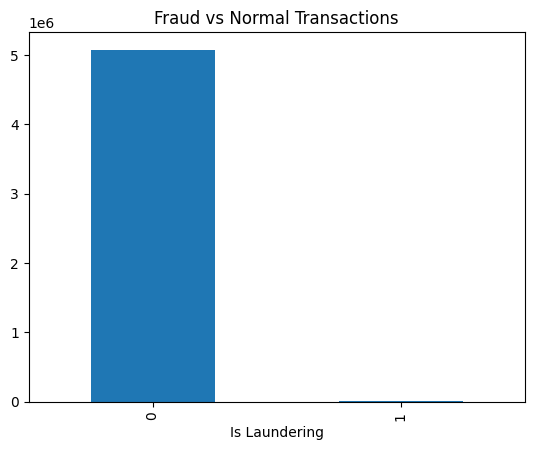

In [ ]:
import matplotlib.pyplot as plt

transactions["Is Laundering"].value_counts().plot(kind="bar")
plt.title("Fraud vs Normal Transactions")
plt.show()

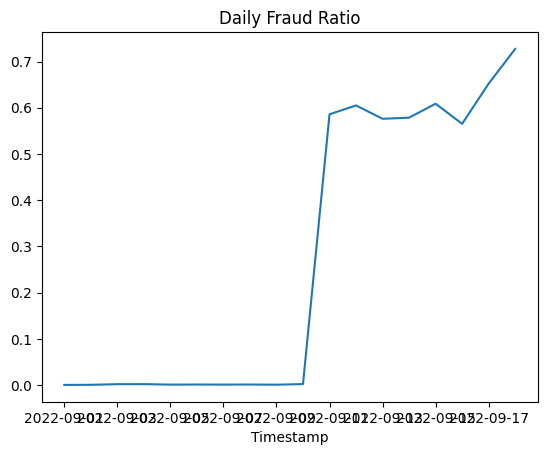

In [ ]:
transactions["Timestamp"] = pd.to_datetime(transactions["Timestamp"])

daily_fraud = (
    transactions.groupby(transactions["Timestamp"].dt.date)["Is Laundering"]
    .mean()
)

daily_fraud.plot()
plt.title("Daily Fraud Ratio")
plt.show()

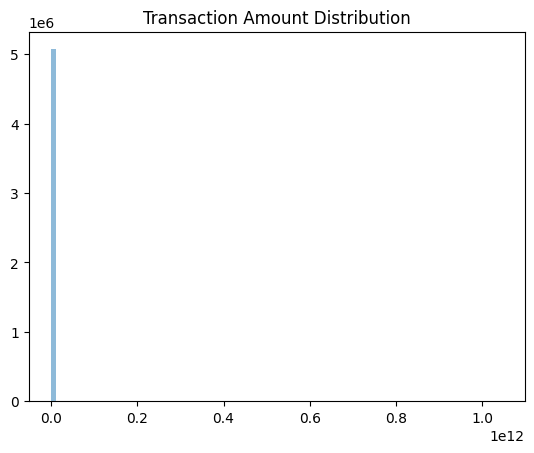

In [ ]:
fraud = transactions[transactions["Is Laundering"] == 1]["Amount Paid"]
normal = transactions[transactions["Is Laundering"] == 0]["Amount Paid"]

plt.hist(normal, bins=100, alpha=0.5)
plt.hist(fraud, bins=100, alpha=0.5)
plt.title("Transaction Amount Distribution")
plt.show()

In [ ]:
merged = transactions.merge(
    accounts,
    left_on="Account",
    right_on="Account Number",
    how="left"
)
merged.head()

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering,Bank Name,Bank ID,Account Number,Entity ID,Entity Name
0,2022-09-01 00:20:00,10,8000EBD30,10,8000EBD30,3697.34,US Dollar,3697.34,US Dollar,Reinvestment,0,National Bank of Laramie,10,8000EBD30,800D232D0,Partnership #1
1,2022-09-01 00:20:00,3208,8000F4580,1,8000F5340,0.01,US Dollar,0.01,US Dollar,Cheque,0,Sappo Cooperative Bank,3208,8000F4580,8008EEA70,Partnership #2
2,2022-09-01 00:00:00,3209,8000F4670,3209,8000F4670,14675.57,US Dollar,14675.57,US Dollar,Reinvestment,0,National Bank of Fort Wayne,3209,8000F4670,800FBB3A0,Partnership #3
3,2022-09-01 00:02:00,12,8000F5030,12,8000F5030,2806.97,US Dollar,2806.97,US Dollar,Reinvestment,0,National Bank of the East,12,8000F5030,800C0EF20,Sole Proprietorship #1
4,2022-09-01 00:06:00,10,8000F5200,10,8000F5200,36682.97,US Dollar,36682.97,US Dollar,Reinvestment,0,National Bank of Laramie,10,8000F5200,800C3EC10,Partnership #4


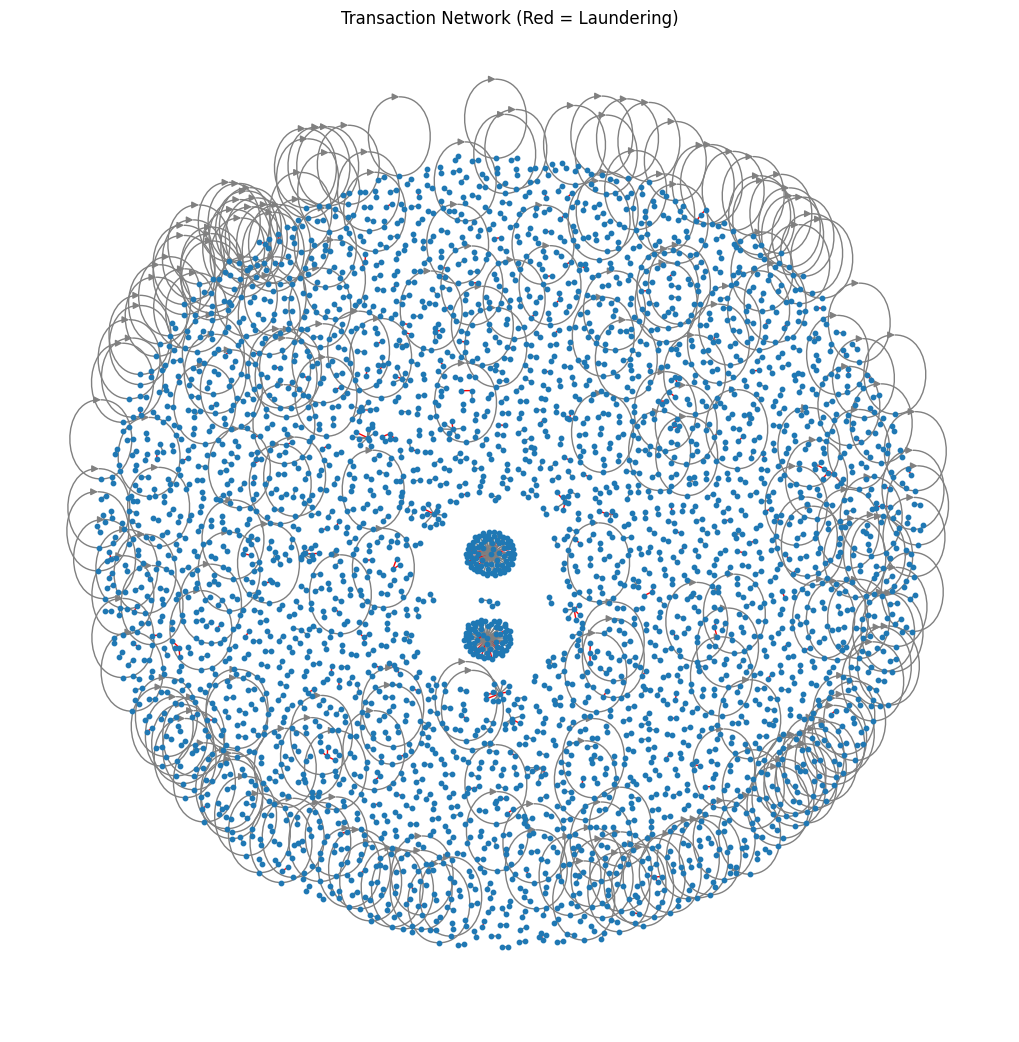

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

fraud = transactions[transactions["Is Laundering"] == 1]
normal = transactions[transactions["Is Laundering"] == 0]

sample = pd.concat([
    fraud.sample(300, random_state=42),      
    normal.sample(2000, random_state=42)     
])

# sample = transactions.sample(3000)

G = nx.from_pandas_edgelist(
    sample,
    source="Account",
    target="Account.1",
    edge_attr="Is Laundering",
    create_using=nx.DiGraph()
)

# edge colors based on laundering
edge_colors = [
    "red" if G[u][v]["Is Laundering"] == 1 else "gray"
    for u, v in G.edges()
]

plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G, seed=42)

nx.draw(
    G,
    pos,
    node_size=10,
    edge_color=edge_colors,
    arrows=False
)

plt.title("Transaction Network (Red = Laundering)")
plt.show()

Not much meanining full data present from this graph

In [ ]:
# checking on the patterns txt file
from pathlib import Path

patterns_file = DATA_DIR / "HI-Small_Patterns.txt"

records = []
current_pattern = None

with open(patterns_file) as f:
    for line in f:
        line = line.strip()

        if line.startswith("BEGIN"):
            current_pattern = line.replace("BEGIN LAUNDERING ATTEMPT - ", "")
            continue

        if line.startswith("END"):
            current_pattern = None
            continue

        if current_pattern and line:
            parts = line.split(",")

            records.append({
                "pattern_type": current_pattern,
                "timestamp": parts[0],
                "from_bank": parts[1],
                "from_account": parts[2],
                "to_bank": parts[3],
                "to_account": parts[4],
                "amount": float(parts[5]),
                "currency": parts[6]
            })

patterns_df = pd.DataFrame(records)
patterns_df["timestamp"] = pd.to_datetime(patterns_df["timestamp"])

patterns_df.head()

,pattern_type,timestamp,from_bank,from_account,to_bank,to_account,amount,currency
0,FAN-OUT: Max 16-degree Fan-Out,2022-09-01 00:06:00,021174,800737690,012,80011F990,2848.96,Euro
1,FAN-OUT: Max 16-degree Fan-Out,2022-09-01 04:33:00,021174,800737690,020,80020C5B0,8630.40,Euro
2,FAN-OUT: Max 16-degree Fan-Out,2022-09-01 09:14:00,021174,800737690,020,80006A5E0,35642.49,Yuan
3,FAN-OUT: Max 16-degree Fan-Out,2022-09-01 09:56:00,021174,800737690,00220,8007A5B70,5738987.96,US Dollar
4,FAN-OUT: Max 16-degree Fan-Out,2022-09-01 11:28:00,021174,800737690,001244,80093C0D0,7254.53,US Dollar


In [ ]:
patterns_df["pattern_type"].value_counts()

pattern_type
SCATTER-GATHER                           626
STACK                                    466
BIPARTITE                                263
GATHER-SCATTER:  Max 12-degree Fan-In    124
GATHER-SCATTER:  Max 10-degree Fan-In    117
                                        ... 
CYCLE:  Max 6 hops                         6
FAN-OUT:  Max 3-degree Fan-Out             6
FAN-OUT:  Max 6-degree Fan-Out             6
FAN-IN:  Max 1-degree Fan-In               4
RANDOM:  Max 4 hops                        4
Name: count, Length: 65, dtype: int64

<Axes: xlabel='timestamp'>

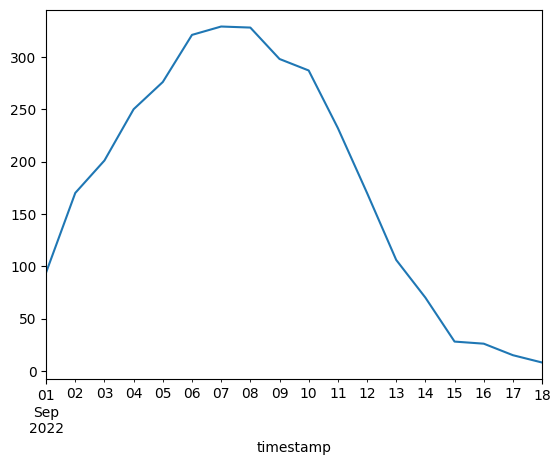

In [ ]:
patterns_df.set_index("timestamp").resample("D").size().plot()


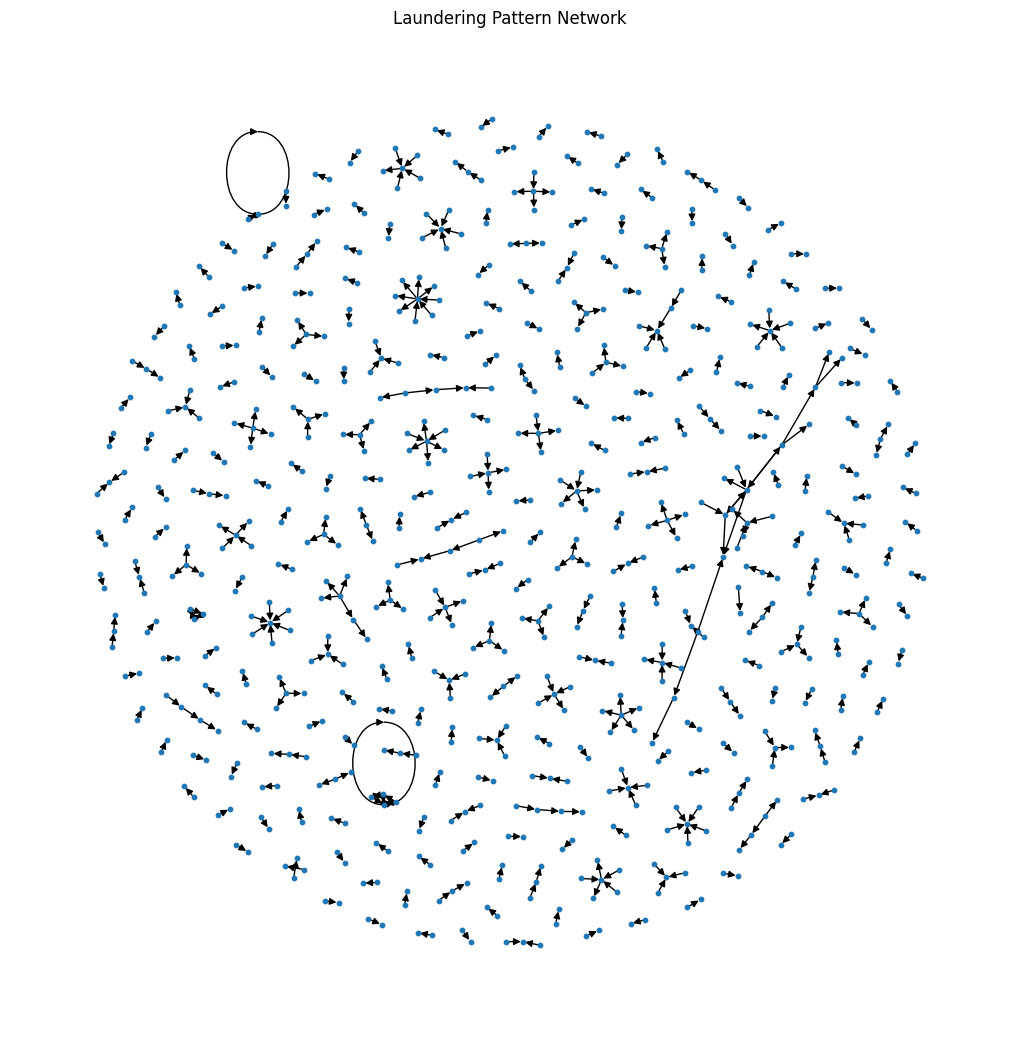

In [ ]:
sample = patterns_df.sample(500)

G = nx.from_pandas_edgelist(
    sample,
    source="from_account",
    target="to_account",
    edge_attr="pattern_type",
    create_using=nx.DiGraph()
)

plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G)

nx.draw(G, pos, node_size=10)
plt.title("Laundering Pattern Network")
plt.show()


In [ ]:
# checking with the accounts
laund_accounts = set(patterns_df["from_account"]) | set(patterns_df["to_account"])
transactions["pattern_involved"] = (
    transactions["Account"].isin(laund_accounts) |
    transactions["Account.1"].isin(laund_accounts)
)
transactions.groupby("pattern_involved")["Is Laundering"].mean()

pattern_involved
False    0.000387
True     0.030115
Name: Is Laundering, dtype: float64